# Predicting Housing Prices with Regression  ------------------------------------------

## Introduction: The Ames Housing Data Set

<img src="images/ames.jpg" width="60%">

The Ames Housing Data Set contains information from the Ames Assessor’s Office used in computing the value of individual residential properties sold in Ames, Iowa from 2006 to 2010, as well as the actual eventual sale prices for the properties.  

The data set contains information for more than 2900 properties.  The **[data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)** outlines more than 75 descriptive variables. Some are **nominal** (categorical), meaning they are non-numerical and lack clear-cut order (Examples: Neighborhood, Type of roofing).  Some are **ordinal**, meaning they are categorical but have a clear order (Example:  Heating Quality (Excellent, Good, Average, Poor)). Some are **discrete**, meaning they are numerical but at set intervals (Year Built, Number of Fireplaces). The rest are **continuous**, meaning they are numerical and can theoretically take any value in a range (1st Floor Square Feet).

In this project, I have attempted to craft as accurate a model as possible for predicting housing sale prices, using regression techniques, enhanced by feature engineering, feature selection, and regularization.  This project was connected to a private Kaggle competition.  The Ames data set was divided into a labeled training set, and an unlabeled test set (the labels exist, but are withheld).  I aim to accurately predict the withheld sale prices for the test set, based on the features and prices in the training set.  This exercise mimics real-world modeling scenarios.  

As in many Kaggle competitions, I upload a set of predictions and receive a score that evaluates my performance on a subset of the test set, but evaluation on the entire test set does not take place until the end of the competition.  This is significant, because it is possible to overfit your model to the subset of the test set that is being used to generate scores. **It is important to prioritize generalizability in a model**, instead of just over-tweaking to maximize your accuracy score on the available subset of test data.   

## Data Cleaning and Processing

A lot of data cleaning and data wrangling were involved in preparing the data for analysis and modeling.  The full code for this part of the project, and the subsequent editing of the test data to match, can be viewed **[here in NBViewer](https://nbviewer.jupyter.org/gist/eamonious/d82a505fcd346af7a9e69d861c4337ad)**.  

Among the changes:

- **Nominal variables were one-hot-encoded**, meaning they were converted into a series of binary variables representing whether each category was true for a given house, yes (1) or no (0). 
- **Ordinal variables were mapped to numerical format.**  At times this can be subjective. If one category is significantly better than the others for example, a simple {0,1,2,3} mapping may not be as appropriate as say, {0,1,2,5}.  In other cases, it may be most accurate to use something like {-2,-1,0,1,2}.  Looking at the counts for each category can be helpful.  In cases where the great majority of houses are in one category, it is often sensible to map this category to 0, and indicate other categories as above or below this "standard".  In general, using the data dictionary and then individual research as needed is essential here.
- **Null or missing values were addressed**, typically either by removing properties with missing data or imputing values for the missing data.  Some imputations were trivial: Houses with no garage had null values for all garage-related variables, these were imputed easily (Add a 'None' category for 'Garage Type', add 0 for Garage Area, etc.).  Other imputations were more complex:  Many values were missing for Lot Frontage (i.e.; the length in feet over which a property is adjacent to the street). 0 was not a sensible imputation here, the houses must have *some* lot frontage. Imputing the mean lot frontage from all houses was an option, but seemed very rough.  I chose instead to impute the mean lot frontage from the neighborhood in which the house was located.

At the end of this process I had a feature table with over 200 variables, and this is prior to any attempts at feature engineering.  I have included images of the variables most highly correlated with sale price, both positively and negatively.  Keep in mind that these may not all be present among the most predictive variables, as some may be highly collinear and cancel out each other's influence.  However we would certainly expect *some* of these top variables to be among our most predictive variables in any final model.  

<img src="images/correlation-top-variables.png">

The full heatmap for correlation with sale price can be viewed **[here](../images/projects/housing/correlation-heatmap.png)**.

## Predicting Sale Price with Regression

In **supervised machine learning**, we build a model to predict a target variable from a set of feature variables, by training it on individuals where the target variable is already known.  Supervised machine learning problems can be broadly divided into two types of problems:  **classification** problems and **regression** problems.  Classification problems involve trying to predict a categorical target variable - we want to classify new individuals into one of n categories.  Regression problems involve trying to predict a continuous target variable - we want to predict the value of the variable for each new individual.  As sale price is continuous, this is a regression problem. 

Regression analysis essentially involves identifying a mapping function that can be applied to a set of feature variable values to generate an estimate of the true target value for a given individual (i.e.; a prediction).  This mapping function is derived by minimizing some **loss function** that indicates the performance accuracy of the mapping function.  The smaller the total loss in our predictions, the closer our predictions are to being correct on average, and the better the performance of the model overall.  

The most basic regression technique available to us is **linear regression**.  In this case our mapping function is limited to the form of a straight line:

$$ \begin{eqnarray} y &=& \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\\ \end{eqnarray} $$ 

In this equation, y represents our target prediction for each individual, the different values of X are the values of the feature variables for each individual, and the different values of $ \beta $ are coefficients that represent the magnitude (positive or negative) of each feature variable's influence on our prediction.  $ \beta_0 $ represents a constant, the y-intercept of our line; it is also theoretically our prediction for the value of a house where all feature variables = 0.  

I will use **sklearn's LinearRegression() method** to run my linear regression.  When I run this, sklearn basically identifies the **line of best fit** for the data it receives; that is, the line (in multidimensional space) which minimizes loss between the line and the target values - the line which gives the best predictions overall for the training data.  The standard loss function used in linear regression is **mean squared error**, or the sum of the squares of the error between the predictions (the line) and the actual target values.  This is why we often hear this referred to as least squares regression; the line of best fit is identified by finding the line that minimizes mean squared error.

The image below depicts a line of best fit for a single feature variable, using the least squares technique.
<img src="">

Each time we run LinearRegression(), it will return the best available line of fit from what it receives, plain and simple. This is the first part of minimizing loss.  The second part, and really the part that we have control over, involves **iteratively improving our model by changing the features that we include** when we run LinearRegression().  This can be accomplished by engineering new features to add predictive value, or eliminating redundant and irrelevant features to prevent overfitting.  This may seem simple at first blush, but with hundreds of features and the ability to engineer many more, it can be quite complicated.  I will go into this below.

After making such changes and establishing a new line of best fit, we can evaluate the performance of our model by checking the **R2 Score**, which essentially calculates the squared error around our fit line as a percentage of the inherent variance in the data and subtracts that from 1.  The R2 score ranges from 0 to 1, and can be thought of as the percentage of variation in the data that is explained by the predictive power of the model.  The higher the score, the better the performance.

**The ultimate goal here is to iteratively minimize the loss in our model's predictions for new data.**  To do this, we want to minimize the loss we observe in our training data, while also preserving generalizability.  These principles extend to even the most complex supervised machine learning problems.

### Import packages and read in cleaned training data

In [639]:
#Import basic packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

#Import model validation and preprocessing packages
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

#Import feature selection packages
from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression

#Import regression and metric packages
from sklearn.metrics import r2_score, recall_score, make_scorer, f1_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor

#Jupyter magics (for notebook visualizations)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#Set viewing max to 300 variables
pd.set_option('max_columns',300)

#Reads in the cleaned training data
X = pd.read_csv('./datasets/data_clean_final.csv')

### Removing Outliers

This step should be regarded as optional, but was important to the overall outcome of the Kaggle competition.  **The data dictionary mentions five observations (houses) that are significant outliers**.  Essentially these were in-family sales where the sale price greatly underestimates the actual value of the home.  The mean squared error for these observations is therefore very large, enough that it significant skews the line of best fit.  

The training set contains three of these five values.  The test set contains two.  However, both are in the withheld portion of the test set.  As a result, if you were trying to win the Kaggle competition, it was necessary to leave these outliers in when building your model, so as to account for their influence on the line of best fit.  However, leaving them in greatly disrupts loss minimization on the available test subset (that contains no outliers) - in other words, leaving the outliers out allowed you to score much better in the Kaggle rankings.  

In my opinion, leaving the outliers in was a flaw in the competition design, because, while instructive about the limitations of loss functions in the presence of outliers, the undersold houses are anomalous cases that take away from the real-world task of trying to accurately assess the price of homes.  I worked around the issue by submitting one model with the outliers and one model without (two submissions were permitted).  For the purposes of demonstrating iterative improvements in model accuracy, I will proceed here with the outliers *excluded*.  You want to do this now, before manipulating the data any further.

In [640]:
#Removes the three extreme Price by Area outliers in the training set
X.drop(959,inplace=True)
X.drop(1882,inplace=True)
X.drop(125,inplace=True)

#Save csv with no outliers
X.to_csv('./datasets/data_clean_no_outliers.csv',index=False)
#Load the new csv in
X = pd.read_csv('./datasets/data_clean_no_outliers.csv')

### Separating the Target and Feature Variables

By convention, the target variable (here the Sale Price) is represented by a lowercase y (because it is a single vector), and the feature variables are represented with an uppercase X (because they comprise a matrix).

In [641]:
#Sets target variable (Sale Price) as y
y = X['SalePrice']

#Sets feature variables (everything but Sale Price and Id) as X
X.drop(['SalePrice','Id'], axis=1, inplace=True)

### Feature Engineering

Feature engineering simply involves creating new variables from those that you already have.  These variables can often add predictive value.  I did some basic feature engineering during the initial data processing stage; for example, using the month-of-sale variable to create a season-of-sale variable, which I felt could be more relevant.  

A more systematic approach to feature engineering is the **PolynomialFeatures** method in sklearn's preprocessing suite. This generates all possible polynomial combinations of a set of features below a specified nth degree (default = 2). In this case we will generate new features from the **square of each feature** (some variables may vary quadratically with sale price instead of linearly, in which case these new features may be more predictive than their first-degree counterparts).  We will also generate new features from the **product of every two features**.  This type of engineered feature is called an **interaction term**, because it represents the interaction effect between two variables.  If two variables have a synergistic effect on sale price, for instance, then the product of the two features may add considerable predictive value.

In [642]:
#Generates the full polynomial feature table.  
poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)
X_poly.shape

(2045, 22577)

In [643]:
#Adds appropriate feature names to all polynomial features
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names(X.columns))

#Generates list of poly feature correlations
X_poly_corrs = X_poly.corrwith(y)
#Shows features most highly correlated (positively) with sale price, poly features included
X_poly_corrs.sort_values(ascending=False).head(20)

Overall Qual Gr Liv Area       0.876299
Bsmt Qual Gr Liv Area          0.843971
Overall Qual 1st Flr SF        0.842331
Overall Qual^2                 0.833020
Overall Qual Total Bsmt SF     0.830507
Overall Qual Garage Area       0.827364
Overall Qual Bsmt Qual         0.824825
Overall Qual Garage Cars       0.824217
Total Bsmt SF Gr Liv Area      0.822287
Overall Qual Year Built        0.812162
Gr Liv Area Garage Area        0.811653
Overall Qual TotRms AbvGrd     0.811520
Overall Qual Garage Yr Blt     0.811197
Overall Qual Year Remod/Add    0.809928
Gr Liv Area Garage Cars        0.809253
Gr Liv Area Exter Qual 2       0.806486
Overall Qual                   0.805477
Overall Qual Yr Sold           0.805454
Gr Liv Area Kitchen Qual 2     0.800986
Garage Area Kitchen Qual 2     0.799663
dtype: float64

In [644]:
#Shows features most highly correlated (negatively) with sale price, poly features included
X_poly_corrs.sort_values().head(5)

Yr Sold Garage Type_Detchd         -0.369763
Garage Type_Detchd                 -0.369751
Garage Type_Detchd^2               -0.369751
Year Built Garage Type_Detchd      -0.369113
Garage Yr Blt Garage Type_Detchd   -0.368788
dtype: float64

Running PolynomialFeatures on our feature set (>200 features to start with) results in **over 20,000 features**!  We can see that **some of them are showing higher correlation with sale price than *any* of our original variables**.  However, these top poly feature variables will often be highly collinear, and most poly features will be completely irrelevant.  The vast majority of features will need to be removed, or our model will end up incredibly overfit to the data.  This is where feature elimination comes into play.

Below are plots of some feature variables against sale price.  We can see discrete vs continuous variables; outlier houses mentioned by the data dictionary; high vs moderate correlations; and faintly curved plots that point toward a possible polynomial relationship with sale price.
<img src="images/feature-plots.jpg" width="85%">

### Feature Elimination and Regularization

The next step in the process will be whittling down our features.  

With a small feature set, feature selection can be done manually.  One might remove individual features and observe how the training score is affected.  Removing a feature will always reduce the training score some amount, but if that amount is very small, the feature can be discarded in favor of model generalizability.  One could continue eliminating the least influential variable until only variables that significantly affect training score remain.  However, with a feature set like the one we have here, this approach isn't feasible.

I experimented with different subsets of polynomial features extensively, and ultimately chose to use just two of the highest correlated polynomial features.  This seemed to return the best results.

In [645]:
#These are the two polynomial features I ended up including.  I decided to just create them manually here.

#Interaction between Overall Quality and Above Ground Living Area (sq. ft)
X['Overall Qual Gr Liv Area'] = X['Overall Qual'] * X['Gr Liv Area']
#Square of Overall Quality
X['Overall Qual^2'] = X['Overall Qual'] * X['Overall Qual']

#I also engineered a feature for total bathrooms, from full baths and half baths.
X['Bathroom total'] = X['Full Bath'] + (0.5 * X['Half Bath'])

#We now have 214 features total.
X.shape

(2045, 214)

A common issue in modeling is **overfitting**.  This occurs when the model you've designed is too closely matched to the training data, to where it picks up the inherent noise in the training data and mistakes it for meaningful underlying structure. The result is that the model does not generalize well to new data.  This typically happens because there are too many parameters or variables involved in the training, and can be resolved by removing some of the complexity while leaving the valuable components intact.  The image below shows how an overfit model can minimize training data error so much that it starts to perform worse on new data.  The error distance from new data points to the model line will be greater on average in the righthand panel than in the middle panel. 

<img src="images/overfitting.png" width=70%>

Running the model on all 20,000+ variables from before, for example, returns an R2 score of around 0.4, while even the most barebones linear regression on the original data gives an R2 score in the area of 0.8.  This is the result of gross overfitting.  

We have removed almost all of the poly features, keeping only the most valuable.  But even after we have chosen to take only two of these engineered variables, we still have 214 feature variables, which is quite a lot.  A good rule of thumb is to have the number of features be somewhere near the square root of the number of observations.  In this case, n=2045 in the training data; the square root of this is ~45. So we can clearly stand to lose some more variables.

One way to eliminate variables is through **regularization**.  

#Discuss L1, L2 Regularization... as well as ElasticNet

In addition to using regularization, I experimented with **manually removing variables that were poorly correlated with sale price**. I found that removing about 100 variables from the 214, prior to fitting a model with regularization, produced the best scoring results. Removing more than this appeared to go too far, beginning to weaken performance and introduce bias by starving the model of information.

In [646]:
#Removes the 100 features least correlated with sale price.
#Specifically, this code makes a sorted list of the magnitude of all feature correlations with sale price,
#drops the 100 smallest correlations, grabs remaining feature names, and condenses feature set to only those features.
features_keep = list(abs(X.corrwith(y)).sort_values(ascending=False)[:-100].index)
X = X[features_keep]

#This additional drop list is based on me then iteratively fitting models and removing features that 
#failed to meet a threshold for predictive influence after regularization
X.drop(['Exterior 1st_CemntBd', 'Foundation_CBlock', 'Neighborhood_dummies_Timber', 'Alley', 'Electrical',
        'Lot Config_Inside', 'Neighborhood_dummies_BrDale', 'Exterior 2nd_HdBoard', 'Exterior 1st_MetalSd',
        'Neighborhood_dummies_NAmes', 'Neighborhood_dummies_BrkSide', 'House Style_2Story', 'MS SubClass_50','Roof Style_Hip',
        'Neighborhood_dummies_Sawyer', 'Mas Vnr Type_BrkFace','MS SubClass_60','Fence','Foundation_Slab','Exterior 2nd_CmentBd',
        'Bedroom AbvGr','Lot Shape','Exterior 2nd_MetalSd','Garage Type_BuiltIn'], axis=1,inplace=True)

### Train Test Split and Standard Scaler

The typical workflow for building a model based on supervised learning from a training set involves creating what is called a **train/test split**. Essentially we are splitting the training data into a training bloc and a testing bloc. We will train the model on the properties in the train bloc and then test it on the properties in the test bloc.  This test bloc is not to be confused with the test set for the Kaggle competition - think of that test set as equivalent to actual real world data that one might want to predict.  This test bloc is a subdivision of our training set that we will use to validate our training process.

The point of creating this train/test split is to make sure that our model generalizes well to new data.  If we simply train on the entire training data set, then our model will likely become **overfit** to the particular data in that set, such that it may actually be worse at predicting the sale price for new houses.  Once we are satisfied that the model we've built generalizes well to new data, *then* we can train it on the full training set (including our test bloc) to incorporate as much information as possible into the model before running it on the test set and submitting the predictions to Kaggle.

When we run train_test_split(X,y), it will create these blocs by randomly splitting the observations in the dataset into one or the other.  
Discuss train test split randomization process and default split size...



Discuss StandardScaler normalizer in context of regularization

In [647]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=19)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

### Cross Validation and GridSearch

Just explain them

Understand that, while I am doing everything only once here, this process of {tweak > train/test split > GridSearch with regularization and cross-validation > evaluate model score} was repeated many times during the iterative process of informed trial and error that is model building.

### Logarithmic Transformation of Sale Prices (y)

Explain here... discuss how normality of errors is an important assumption in linear regression... this transformation improves the model by making that assumption much more valid.

In [648]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

<img src="images/log-transform.jpg">

### GridSearch with ElasticNet

Here, finally, we will actually fit our model and evaluate its performance!  Parameter grid, etc...

In [649]:
param_grid_1 = {
    'alpha':[.1,.3,.5,1,5],
    'l1_ratio':[0,.3,.5,.7,1]
}

gs = GridSearchCV(ElasticNet(),param_grid_1,cv=5,verbose=1)

gs.fit(X_train_sc,y_train_log)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   12.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 0.3, 0.5, 1, 5], 'l1_ratio': [0, 0.3, 0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [650]:
#Returns the best parameters
gs.best_params_

{'alpha': 0.1, 'l1_ratio': 0}

In [651]:
#Returns the R2 score of the best parameters
gs.best_score_

0.907810798394713

In [652]:
gs.score(X_test_sc,y_test_log)

0.9277476223187144

Our model is close to 0.93 on the unseen data!  In other words, our model explains almost 93% of variation in sale price in the test bloc data, which it has not trained on.  There is no evidence of overfitting, and this result is well above baseline.  This looks great.   

In [653]:
#creates table of all feature variables and their model coefficients
coef_table = pd.DataFrame(gs.best_estimator_.coef_, index=X_train.columns, columns=['Coefficients'])
#creates column with coefficient magnitudes
coef_table['Magnitude']=abs(coef_table['Coefficients'])
#sorts features by coefficient magnitude (i.e.; predictive power) and shows top 25 most influential features
coef_table.sort_values('Magnitude',ascending=False).head(25)['Coefficients']

Gr Liv Area                     0.049065
Overall Qual                    0.043713
Overall Cond                    0.041728
1st Flr SF                      0.038843
Overall Qual Gr Liv Area        0.031253
Total Bsmt SF                   0.031057
MS Zoning_RL                    0.025186
2nd Flr SF                      0.022557
Functional                     -0.022105
Overall Qual^2                  0.021076
Lot Area                        0.020428
Year Built                      0.020031
Paved Drive                     0.020002
BsmtFin SF 1                    0.019416
Neighborhood_dummies_IDOTRR    -0.018671
Heating QC                      0.017885
Central Air_Y                   0.017848
MS SubClass_30                 -0.017788
Neighborhood_dummies_OldTown   -0.017120
MS Zoning_FV                    0.016879
Garage Cond                     0.015198
Fireplaces                      0.015085
Neighborhood_dummies_MeadowV   -0.014556
Neighborhood_dummies_NridgHt    0.014143
Bsmt Qual       

**The top predictive features that we see here are *very* plausible**.  At the very top, we have above ground living area, overall quality, overall condition, basement living area.  Then: Properties zoned as residential low density are associated with higher price; functional deficits correspond to lower price; lot area; houses built more recently sell higher. After that, central AC, high quality heating, finished basements and paved driveways are in the next tier of factors that predict high price.  We also see the influence of a few neighborhoods, for better or worse ("Location, location!").  The model certainly seems sound.

### Plotting Predictions

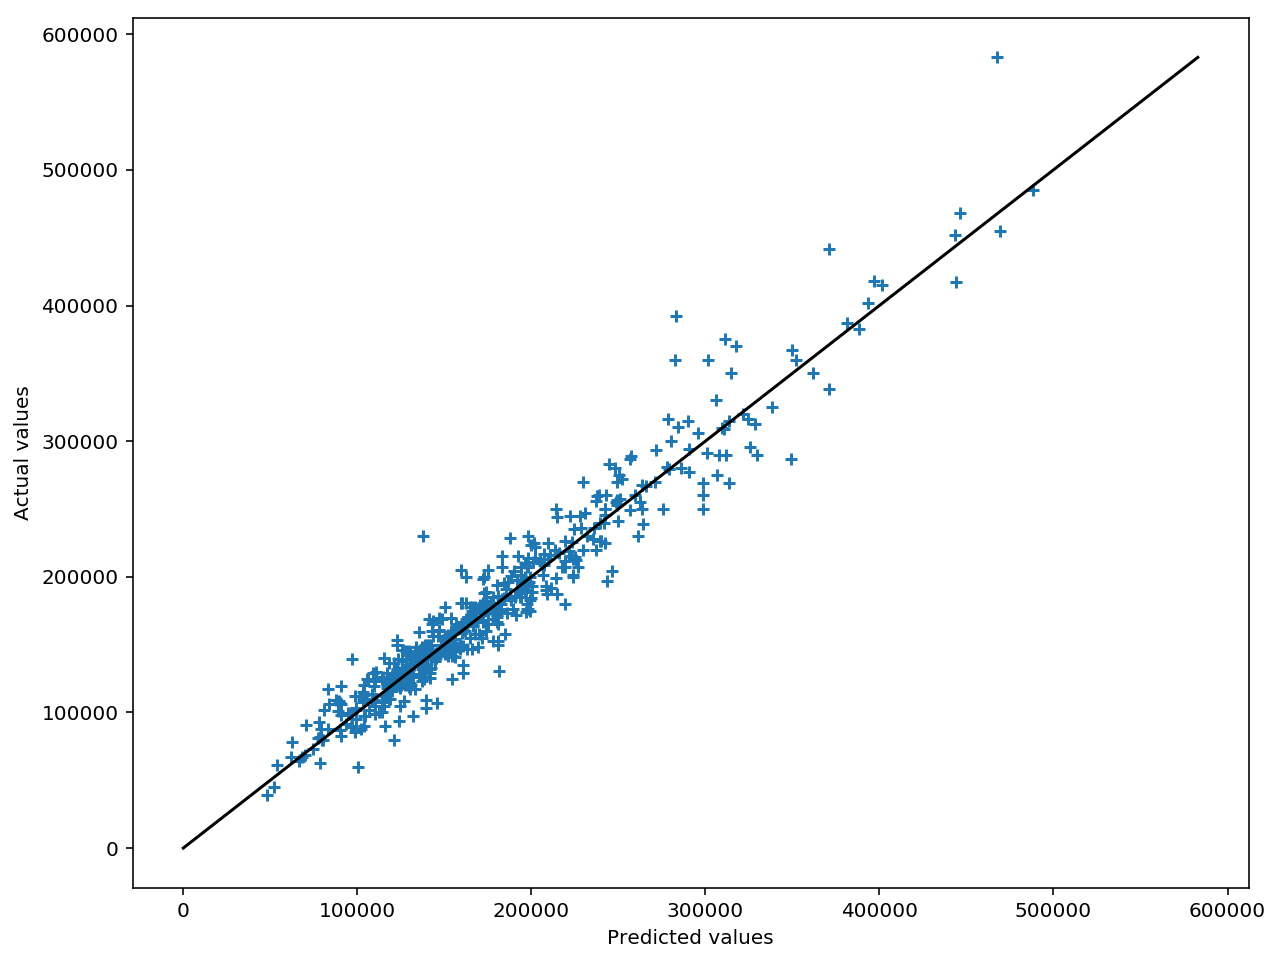

In [654]:
#Generates a list of the model's predictions for the test bloc
preds = gs.predict(X_test_sc)

#Plots predicted values against actual values in the train/test split.
plt.figure(figsize=(10,8))
plt.scatter(np.exp(preds),y_test,marker = '+')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.plot([0,np.max(y_test)],[0,np.max(y_test)], c = 'k');

## Re-train on Full Training Set and Submit Test Set Predictions

Once we are satisfied with the performance of our model on the test bloc, we can use the same parameters and re-fit (or re-train) our model on the entire training set (train bloc *and* test bloc) to give it as much learning data as possible, then use that model to generate our predictions for the Kaggle test set, and submit the list to the competition.  

In [655]:
#Initializes model for whole training set
gs_full_trainset = gs.best_estimator_
#Applies StandardScaler normalization to whole training set
X_sc = ss.fit_transform(X)
#Log transformation of sale price for whole training set
y_log = np.log(y)

#Re-fits the model
gs_full_trainset.fit(X_sc,y_log)
#Scores the model (training score only, of course)
gs_full_trainset.score(X_sc,y_log)

0.9237092311611361

The training score has increased from .908 to .928; the model should be more accurate now.  

The submission format is particular to the competition, but the important thing to remember is **we must use np.exp() on our predicted sale prices to reverse the log transformation** before submitting anything!  Otherwise we will submit a bunch of laughably low values.

In [660]:
testset = pd.read_csv('./datasets/test_clean_final.csv')
#Drops Id column like we did earlier to the training set.  
#Recall that there is no SalePrice info in the test set.
testset.drop('Id',axis=1,inplace=True)

#Apply feature engineering changes to test set (This layout allows easy iterative manipulation)
def changes_to_testset(X):
    X['Overall Qual Gr Liv Area'] = X['Overall Qual'] * X['Gr Liv Area']
    X['Overall Qual^2'] = X['Overall Qual'] * X['Overall Qual']
    X['Bathroom total'] = X['Full Bath'] + (0.5 * X['Half Bath'])

changes_to_testset(testset)

#Apply feature elimination changes to test set
testset = testset[features_keep]
testset.drop(['Exterior 1st_CemntBd', 'Foundation_CBlock', 'Neighborhood_dummies_Timber', 'Alley', 'Electrical',
        'Lot Config_Inside', 'Neighborhood_dummies_BrDale', 'Exterior 2nd_HdBoard', 'Exterior 1st_MetalSd',
        'Neighborhood_dummies_NAmes', 'Neighborhood_dummies_BrkSide', 'House Style_2Story', 'MS SubClass_50','Roof Style_Hip',
        'Neighborhood_dummies_Sawyer', 'Mas Vnr Type_BrkFace','MS SubClass_60','Fence','Foundation_Slab','Exterior 2nd_CmentBd',
        'Bedroom AbvGr','Lot Shape','Exterior 2nd_MetalSd','Garage Type_BuiltIn'], axis=1,inplace=True)

#Scale test set
testset_sc = ss.transform(testset)

#Generate model predictions for test set
predictions = gs_full_trainset.predict(testset_sc)

#Reverse log transformation of sale prices
predictions = np.exp(predictions)

#Create submission csv in proper format
testset['SalePrice'] = predictions
testfile = pd.read_csv('./datasets/test_clean_final.csv') 
testset['Id'] = testfile['Id']
submission = testset[['Id','SalePrice']]
submission.to_csv('./datasets/kaggle_submission.csv',index=False)

#View submission
submission.head()

,Id,SalePrice
0,2658,131735.045798
1,2718,161712.371720
2,2414,213190.508797
3,1989,98091.841544
4,625,174739.263850


## Conclusions

By using feature engineering, feature elimination, and (where applicable) target variable transformation, we can reduce loss and *greatly* improve the performance of even a basic model like linear regression.

### Model Improvement

In the image below, I have visualized progressive improvement in the model, from a basic ...



### The Importance of Outliers

As I mentioned earlier on, the five outlier houses mentioned in the data dictionary had a significant effect on final model performance.  I submitted one model with the outliers *excluded*, which allowed me to score accurately on the ranking board (and have a sense of how well my iterative changes were performing on the pure data), and one model with the outliers *included*, because I suspected this would be necessary to do well in the final evaluation on the whole test set.  

85 participants submitted models to the competition.  My model *without outliers* ranked **2nd** in accuracy on the subset of the test data used for scoring, which contained no outliers.  My model without outliers would have ranked in the low 20s at this point (only top scores were ranked).

In the actual competition results, evaluated on the entire test set, which included two of the outliers, my model *with outliers* was my top performing model, and ranked **5th** overall.  Clearly, the influence of the outliers on mean squared error was predominant, but the underlying model appears to have been sound.  I was the only participant ranked in the top 10 on both boards.

### Interpretability of Linear Regression

Linear Regression may be a basic method when it comes to predictive accuracy.  But predicting the sale price of a house isn't everything.  In fact, **knowing what factors influence the selling price of a house may well be more valuable than the predictions themselves**.  

One of the great advantages of linear regression relative to more complex techniques is its **interpretability**.  Not only can we identify which features exert the most influence on our predictions, we even have the relative magnitude and direction of their influence, as given by the associated coefficients.  This information can be very useful. When using more complex and high-powered modeling techniques like gradient boosting or neural networks, we will tend to get higher predictive accuracy, but much more limited interpretability.  This is one of the great trade-offs in data science.